# Reinforced Learning over simplified Neutreeko

This work consist on creating an agent capable of playing a simplified version of the game Neutreeko (https://www.neutreeko.net/neutreeko.htm).

![alt text](https://i.imgur.com/qeEH8e2.jpg)

In the simplified version, the game starts with a randomly generated 5x5 board with 3 black pieces. The Agent can move any piece in one of the 4 possible directions: UP, DOWN, LEFT, RIGHT. After choosing a direction and a piece, the selected piece will move in that direction until colliding with an edge of the board or another piece.

The game ends when 200 rounds pass or when the player is able to place 3 pieces together in a row, column or diagonally.



## Necessary imports
- gym
- numpy
- matplotlib
- typing (only used for documentation)

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Union

## Game Logic and Engine

To keep a record of the possible moves we created the dictionary `EASY_ACTIONS_DICT` and also keep the board size as a global variable.

The class `NeutreekoUtils` has some helper functions used by the game such has:
- `search_sequence_numpy` To find a sequence in a array
- `find_sequence_board` To find a sequence in a board 
- `value_in_board` To get a value in a board position
- `replace_in_board` To replace the value in a position of the board

In [2]:
EASY_ACTIONS_DICT = {
    'UP': (-1, 0),
    'DOWN': (+1, 0),
    'LEFT': (0, -1),
    'RIGHT': (0, +1),
}

BOARD_SIZE = 5

In [3]:
class NeutreekoUtils:
    @staticmethod
    def search_sequence_numpy(arr, seq) -> bool:
        """
        Find sequence in an array using NumPy only.
        :param arr: input 1D array
        :param seq: input 1D array
        :return: True if the seq is in the arr
        """

        # Store sizes of input array and sequence
        Na, Nseq = arr.size, seq.size

        # Range of sequence
        r_seq = np.arange(Nseq)

        # Create a 2D array of sliding indices across the entire length of input array.
        # Match up with the input sequence & get the matching starting indices.
        M = (arr[np.arange(Na-Nseq+1)[:, None] + r_seq] == seq).all(1)

        # Return true if the sequence exists
        return M.any() > 0

    @staticmethod
    def find_sequence_board(board: np.array, sequence) -> bool:
        """
        Given a board, attempts to find a sequence in all possible directions
        :param board:
        :param sequence:
        :return: True if the sequence is in the board, False otherwise
        """
        for i in range(len(board)):
            # Check in lines
            if NeutreekoUtils.search_sequence_numpy(board[i, :], sequence):
                return True
            # check in columns
            if NeutreekoUtils.search_sequence_numpy(board[:, i], sequence):
                return True

        # check victory in diagonals
        flipped_board = np.fliplr(board)
        for i in range(-2, 3):
            diagonal1 = np.diagonal(board, offset=i)
            if NeutreekoUtils.search_sequence_numpy(diagonal1, sequence):
                return True
            diagonal2 = np.diagonal(flipped_board, offset=i)
            if NeutreekoUtils.search_sequence_numpy(diagonal2, sequence):
                return True

        return False

    @staticmethod
    def value_in_board(board, coords: Tuple[int, int]) -> int:
        """
        Returns the value in the board

        :param board: A np array of size (5,5)
        :param coords: The x and y coordinates of a spot
        :return: The integer value in the board
        """
        if (coords[0] < 0) | (coords[0] >= BOARD_SIZE) | (coords[1] < 0) | (coords[1] >= BOARD_SIZE):
            return False
        return board[coords[0], coords[1]]

    @staticmethod
    def replace_in_board(board, coords: Tuple[int, int], value: int) -> Union[None, bool]:
        """
        Replaces a value in the board

        :param board: A np array of size (5,5)
        :param coords: The x and y coordinates of a spot
        :param value: the value to be in the board
        :return: None or False if the coords are not valid
        """
        if (coords[0] < 0) | (coords[0] >= BOARD_SIZE) | (coords[1] < 0) | (coords[1] >= BOARD_SIZE):
            return False
        board[coords[0], coords[1]] = value

### Game Logic 

For the game logic, we created the class `NeutreekoEasyGame` where we are able to:
- Create a new randomly gerenated initial board - `new_board()`
- Check if a direction of the `EASY_ACTIONS_DICT` is valid - `check_direction()`
- Retrieve a list of all available directions for a piece - `available_directions()`
- Retrieve a list of all possible moves for a player - `get_possible_moves()`
- Perform a move, altering the board - `action_handler()`

In [4]:
class NeutreekoEasyGame:
    def __init__(self):
        self.board = None
        self.current_player = None
        self.game_over = None
        self.turns_count = None

    def reset(self) -> None:
        """
        Resets the game, with a new board, turns count to 0 and designates the first player
        :return:
        """
        self.board = self.new_board()
        self.current_player = 1
        self.game_over = False
        self.turns_count = 0

    @staticmethod
    def new_board() -> np.array:
        """
        Returns a random starting board, each element is a numpy.int8 (-128, 127)

        :return: numpy.array
        """
        board = np.array([[0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0]], dtype=np.int8)
        piece_1_x = np.random.randint(0, 5)
        piece_1_y = np.random.randint(0, 5)

        piece_2_x = np.random.randint(0, 5)
        piece_2_y = np.random.randint(0, 5)
        while (piece_1_x == piece_2_x) & (piece_1_y == piece_2_y):
            piece_2_x = np.random.randint(0, 5)
            piece_2_y = np.random.randint(0, 5)

        piece_3_x = np.random.randint(0, 5)
        piece_3_y = np.random.randint(0, 5)
        while ((piece_1_x == piece_3_x) & (piece_1_y == piece_3_y)) | ((piece_2_x == piece_3_x) & (piece_2_y == piece_3_y)):
            piece_3_x = np.random.randint(0, 5)
            piece_3_y = np.random.randint(0, 5)

        board[piece_1_x][piece_1_y] = 1
        board[piece_2_x][piece_2_y] = 1
        board[piece_3_x][piece_3_y] = 1

        return board

    def value_in_board(self, position: Tuple[int, int]) -> int:
        """
        Returns the value in a position of the board

        :param position: Tuple with 2 ints representing the coordinates of a cell
        :return: The int value
        """
        return NeutreekoUtils.value_in_board(self.board, position)

    def replace_in_board(self, position: Tuple[int, int], value: int) -> None:
        """
        Replaces a value in a board position

        :param position: Tuple with 2 ints representing the coordinates of a cell
        :param value: Value of a player
        :return: None
        """
        NeutreekoUtils.replace_in_board(self.board, position, value)

    def free_cell(self, coords: Tuple[int, int]) -> bool:
        """
        Checks if a cell is within bounds of the board and if it is free (value is 0)

        :param coords: Tuple with 2 ints representing the coordinates of a cell
        :return: True if the cell equals 0 and is within bounds
        """
        if (coords[0] < 0) | (coords[0] >= BOARD_SIZE) | (coords[1] < 0) | (coords[1] >= BOARD_SIZE):
            return False
        value = self.value_in_board(coords)
        return value == 0

    def check_direction(self, coords: Tuple[int, int], direction: str) -> Union[None, Tuple[int, int]]:
        """
        Returns the resulting position given a starting position and a direction.
        If the direction is not valid (can't make progress in that direction), returns None

        :param coords: Coordinates of intial point
        :param direction: String representation of the direction to take
        :return: None if direction is not valid OR tuple with new coords of resulting positions
        """
        action_coords = EASY_ACTIONS_DICT[direction]
        attempt_coords = tuple(np.add(coords, action_coords))
        free_cell = self.free_cell(attempt_coords)
        if not free_cell:
            return None
        # apply direction until it reaches EOB (end of board) or another piece
        while free_cell:
            new_coords = attempt_coords
            attempt_coords = tuple(np.add(new_coords, action_coords))
            free_cell = self.free_cell(attempt_coords)
        return new_coords

    def available_directions(self, coords: Tuple[int, int]) -> List[str]:
        """
        Finds which directions are available for a piece on the coords tuple

        :param coords: The coordinates of a piece
        :return: A list of directions
        """
        dirs = []
        for action_name in EASY_ACTIONS_DICT.keys():
            result = self.check_direction(coords, action_name)
            if result:
                dirs.append(action_name)
        return dirs

    def get_possible_moves(self, player: int, only_valid: bool = False) -> List[int]:
        """
        Return all the possible moves for a given player with the current board

        :param player: Integer representing the player
        :param only_valid: returns only the valid moves
        :return: A list of ints representing possible actions
        """
        dirs_value = {
            'UP': 0,
            'DOWN': 1,
            'LEFT': 2,
            'RIGHT': 3
        }
        possible_moves = []

        # Find player piece positions
        result = np.where(self.board == player)
        list_of_coordinates = list(zip(result[0], result[1]))

        # for each player piece
        piece_value = 0
        for pos in list_of_coordinates:
            if only_valid:
                # checks which directions are available
                dirs = self.available_directions(pos)
                for dir in dirs:
                    value = 4*piece_value + dirs_value[dir]
                    possible_moves.append(value)
            else:
                # adds every direction
                for dir in EASY_ACTIONS_DICT.keys():
                    possible_moves.append(4*piece_value + dirs_value[dir])
            piece_value += 1
        return possible_moves

    def action_handler(self, pos, dir) -> Union[None, Tuple[tuple, str]]:
        """
        Effectuates the movement of the piece in pos, in the direction dir

        :param pos: The position of the piece that will be moved
        :param dir: The direction that the piece will be moved to
        :return: A tuple with the resulting position and the move type. None if the move is not valid
        """
        result = self.check_direction(pos, dir)
        if not result:
            return None

        self.update_game(pos, result)
        self.turns_count += 1

        self.game_over = NeutreekoUtils.find_sequence_board(self.board, np.array([1, 1, 1]))

        move_type = "win" if self.game_over else "default"
        return result, move_type

    def update_game(self, pos, result) -> None:
        """
        Replaces the piece in the board
        :param pos: initial position of the piece
        :param result: final position of the piece
        """
        self.replace_in_board(result, 1)
        self.replace_in_board(pos, 0)
        pass

    def render(self) -> None:
        """
        Renders the game on the screen
        """
        print(self.board)

## Environments

After having the game engine correctly working, we can implement the simplified Neutreeko environment as the `NeutreekoEasyEnv` class with the methods `init`, `step`, `render`, `close` and `reset`. 

The Environment also needs a helper class `Reward` that holds the reward for each type of move.

In [5]:
class Reward:
    @staticmethod
    def get(move_type):
        """
        Chooses a reward value based on the type of action
        :param move_type: type of action
        :return: the reward value
        """
        return {
            "win": 20,  # winning move
            # "2_row": 5,  # places 2 pieces together
            # "between": 2,  # gets in between 2 opponent pieces
            "default": -1  # makes a move (negative to not enforce unnecessary moves)
        }.get(move_type, -1)

In [6]:
class NeutreekoEasyEnv(gym.Env):
    """
    Description:
       In a 5x5 board there are 3 black pieces in a random formation
       The black pieces can move in any direction, they can move until
       they collide with another piece or the edge of the board
       The game ends when the 3 pieces make a line in any direction
    Source:
       This environment corresponds to a simplified version of the Neutreeko game
       Specified here: https://www.neutreeko.net/neutreeko.htm
    Observation:
       Type: Discrete(2300)

        [[0, 1, 0, 1, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0]]

       All possible board combinations
    Actions:
       Type: Discrete(12)

       Num   Action
       0      0-UP
       1      0-DOWN
       2      0-LEFT
       3      0-RIGHT
       4      1-UP
       5      1-DOWN
       6      1-LEFT
       7      1-RIGHT
       8      2-UP
       9      2-DOWN
       10     2-LEFT
       11     2-RIGHT

          UP   DOWN  LEFT  RIGHT
       0  0     1     2     3
       1  4     5     6     7
       2  8     9     10    11

       The piece 0 is the one with the lowest index. For a piece in coords (x, y), its index is 5*x + y.
    Reward:
       Reward class
    Starting State:
        A randomly generated board
    Episode Termination:
       The player makes 3 in a row
       Episode length is greater than 200.
   """
    metadata = {
        'render.modes': ['terminal']
    }

    def __init__(self, render_mode='terminal', max_turns=200):
        super(NeutreekoEasyEnv, self).__init__()

        # 3 pieces and 4 directions possible
        self.action_space = gym.spaces.Discrete(3*4)
        self.observation_space = gym.spaces.Discrete(2300)

        self.render_mode = render_mode
        self.max_turns = max_turns

        self.game = NeutreekoEasyGame()
        pass

    def step(self, action: int) -> Tuple[object, float, bool, dict]:
        """
        Performs an action on the game and returns info
        :param action:
        :return: observation, reward, done, info
        """
        reward = 0
        info = {
            'old_state': np.copy(self.game.board),
            'turn': self.game.turns_count,
            'action': action,
            'direction': None,
        }

        assert not self.done
        # if self.done:
        #     logger.warn("You are calling 'step()' even though this environment has already returned done = True."
        #                 "You should always call 'reset()' once you receive 'done = True'"
        #                 "-- any further steps are undefined behavior.")
        pos, dir = self.process(action)
        move_check = self.game.action_handler(pos, dir)
        if move_check:
            new_pos, move_type = move_check
            reward = Reward.get(move_type)
            info['direction'] = dir
            info['new_position'] = new_pos

        return self.observation, reward, self.done, info

    def reset(self) -> None:
        """
        Resets the game
        """
        self.game.reset()

    def render(self, mode='terminal') -> None:
        """
        Renders the game according to the mode
        :param mode: terminal or GUI
        :return:
        """
        if mode == 'terminal':
            self.game.render()

    def close(self):
        """
        Closes the environment and terminates anything if necessary
        """
        pass

    @property
    def done(self) -> bool:
        """
        Checks if the game is done or the max turns were reached
        :return: True if the game is done, false otherwise
        """
        game_over = self.game.game_over
        too_many_turns = (self.game.turns_count > self.max_turns)
        return game_over or too_many_turns

    @property
    def observation(self) -> np.array:
        """
        Returns the game board
        :return: The board as a numpy array
        """
        return np.copy(self.game.board)

    def process(self, action: int) -> Tuple[tuple, str]:
        """
        Convert a action into a position and direction
        :param action: A integer between 0 and 11 representing an action
        :return: A tuple with a position (tuple) and a direction
        """
        directions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        result = np.where(self.game.board == 1)
        list_of_coordinates = list(zip(result[0], result[1]))
        return list_of_coordinates[action // 4], directions[action % 4]


## Agent Analysis
### Random Agent

To test if the environment and engine are working correctly, we can use a Agent that chooses random moves. The unused methods will be used for other agents.

In [7]:
class RandomAgent:
    def __init__(self):
        pass

    def choice(self, env) -> int:
        """
        Given the environment, choose the action to take using randomness
        :param env: A Game environment
        :return: the action to take
        """
        player = env.game.current_player
        possible_moves = env.game.get_possible_moves(player, only_valid=True)
        i_random = np.random.randint(len(possible_moves))
        return possible_moves[i_random]

With the Agent implemented, we can test run the agent, environment and engine with a simplified game loop

In [8]:
env = NeutreekoEasyEnv(render_mode='terminal')
random_agent = RandomAgent()

# Creating lists to keep track of rewards
training_rewards = []

NB_EPISODES = 1000
for episode in range(1, NB_EPISODES + 1):
    # Resetting the environment each time as per requirement
    env.reset()
    # Starting the tracker for the rewards
    total_training_rewards = 0

    done = False
    while not done:
        action = random_agent.choice(env)
        obs, reward, done, info = env.step(action)
        total_training_rewards += reward
    print(f"Episode {episode: <4} finished after {env.game.turns_count} turns")

    # Adding the total reward
    training_rewards.append(total_training_rewards)
env.close()

Episode 1    finished after 23 turns
Episode 2    finished after 3 turns
Episode 3    finished after 36 turns
Episode 4    finished after 3 turns
Episode 5    finished after 121 turns
Episode 6    finished after 35 turns
Episode 7    finished after 15 turns
Episode 8    finished after 7 turns
Episode 9    finished after 136 turns
Episode 10   finished after 94 turns
Episode 11   finished after 41 turns
Episode 12   finished after 83 turns
Episode 13   finished after 24 turns
Episode 14   finished after 135 turns
Episode 15   finished after 4 turns
Episode 16   finished after 38 turns
Episode 17   finished after 124 turns
Episode 18   finished after 4 turns
Episode 19   finished after 28 turns
Episode 20   finished after 55 turns
Episode 21   finished after 49 turns
Episode 22   finished after 8 turns
Episode 23   finished after 57 turns
Episode 24   finished after 25 turns
Episode 25   finished after 24 turns
Episode 26   finished after 18 turns
Episode 27   finished after 11 turns
Epi

Episode 226  finished after 34 turns
Episode 227  finished after 106 turns
Episode 228  finished after 79 turns
Episode 229  finished after 2 turns
Episode 230  finished after 78 turns
Episode 231  finished after 34 turns
Episode 232  finished after 13 turns
Episode 233  finished after 7 turns
Episode 234  finished after 87 turns
Episode 235  finished after 75 turns
Episode 236  finished after 168 turns
Episode 237  finished after 146 turns
Episode 238  finished after 17 turns
Episode 239  finished after 50 turns
Episode 240  finished after 58 turns
Episode 241  finished after 80 turns
Episode 242  finished after 39 turns
Episode 243  finished after 11 turns
Episode 244  finished after 86 turns
Episode 245  finished after 68 turns
Episode 246  finished after 20 turns
Episode 247  finished after 40 turns
Episode 248  finished after 24 turns
Episode 249  finished after 2 turns
Episode 250  finished after 20 turns
Episode 251  finished after 19 turns
Episode 252  finished after 20 turns
E

Episode 449  finished after 121 turns
Episode 450  finished after 8 turns
Episode 451  finished after 48 turns
Episode 452  finished after 67 turns
Episode 453  finished after 94 turns
Episode 454  finished after 16 turns
Episode 455  finished after 11 turns
Episode 456  finished after 17 turns
Episode 457  finished after 23 turns
Episode 458  finished after 16 turns
Episode 459  finished after 20 turns
Episode 460  finished after 88 turns
Episode 461  finished after 37 turns
Episode 462  finished after 64 turns
Episode 463  finished after 1 turns
Episode 464  finished after 82 turns
Episode 465  finished after 29 turns
Episode 466  finished after 23 turns
Episode 467  finished after 14 turns
Episode 468  finished after 123 turns
Episode 469  finished after 21 turns
Episode 470  finished after 27 turns
Episode 471  finished after 14 turns
Episode 472  finished after 17 turns
Episode 473  finished after 84 turns
Episode 474  finished after 53 turns
Episode 475  finished after 26 turns
E

Episode 677  finished after 21 turns
Episode 678  finished after 62 turns
Episode 679  finished after 110 turns
Episode 680  finished after 9 turns
Episode 681  finished after 126 turns
Episode 682  finished after 46 turns
Episode 683  finished after 11 turns
Episode 684  finished after 54 turns
Episode 685  finished after 10 turns
Episode 686  finished after 25 turns
Episode 687  finished after 6 turns
Episode 688  finished after 6 turns
Episode 689  finished after 68 turns
Episode 690  finished after 8 turns
Episode 691  finished after 5 turns
Episode 692  finished after 8 turns
Episode 693  finished after 50 turns
Episode 694  finished after 83 turns
Episode 695  finished after 8 turns
Episode 696  finished after 7 turns
Episode 697  finished after 19 turns
Episode 698  finished after 22 turns
Episode 699  finished after 33 turns
Episode 700  finished after 21 turns
Episode 701  finished after 14 turns
Episode 702  finished after 115 turns
Episode 703  finished after 38 turns
Episod

Episode 901  finished after 82 turns
Episode 902  finished after 9 turns
Episode 903  finished after 40 turns
Episode 904  finished after 10 turns
Episode 905  finished after 3 turns
Episode 906  finished after 26 turns
Episode 907  finished after 77 turns
Episode 908  finished after 21 turns
Episode 909  finished after 117 turns
Episode 910  finished after 38 turns
Episode 911  finished after 47 turns
Episode 912  finished after 35 turns
Episode 913  finished after 5 turns
Episode 914  finished after 39 turns
Episode 915  finished after 21 turns
Episode 916  finished after 60 turns
Episode 917  finished after 97 turns
Episode 918  finished after 5 turns
Episode 919  finished after 105 turns
Episode 920  finished after 41 turns
Episode 921  finished after 88 turns
Episode 922  finished after 96 turns
Episode 923  finished after 3 turns
Episode 924  finished after 20 turns
Episode 925  finished after 37 turns
Episode 926  finished after 49 turns
Episode 927  finished after 41 turns
Epis

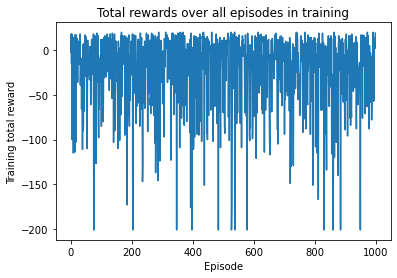

In [9]:
# Visualizing results and total reward over all episodes
x = range(NB_EPISODES)
plt.plot(x, training_rewards)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training')
plt.show()

With the Random Agent there isn't any kind of learning and the total reward for each episode is mostly negative.

### Q-Learning Agent

With Q-learning, the agent keeps a *Q-table* that stores information about each reward after performing a move on a state and analysing the new originated state. The agent uses this line to update the table:
```python
self.Q[state, action] = self.Q[state, action] + self.alpha * (reward + self.discount_factor * np.max(self.Q[new_state, :]) - self.Q[state, action])
```


In [10]:
class QAgent:
    def __init__(self, observation_space=2300, action_space=12):
        """
        Initialize an agent and its parameters

        :param observation_space: How many possible states there are
        :param action_space: How many actions there are
        """
        self.Q = np.zeros((observation_space, action_space))

        self.alpha = 0.7  # learning rate
        self.discount_factor = 0.618
        self.epsilon = 1
        self.max_epsilon = 1
        self.min_epsilon = 0.01
        self.decay = 0.003

        self.board_dict = {}
        self.lastID = None

    def choice(self, env) -> int:
        """
        Given the environment, choose the action to take

        :param env: A Game environment
        :return: the action to take
        """
        # Choosing an action given the states based on a random number
        exp_exp_tradeoff = np.random.uniform(0, 1)

        if repr(env.observation) not in self.board_dict:
            if self.lastID:
                self.lastID += 1
            else:
                self.lastID = 0
            self.board_dict[repr(env.observation)] = self.lastID
            state = self.lastID
        else:
            state = self.board_dict[repr(env.observation)]
        # STEP 2: FIRST option for choosing the initial action - exploit
        # If the random number is larger than epsilon: employing exploitation
        # and selecting best action
        if exp_exp_tradeoff > self.epsilon:
            action = np.argmax(self.Q[state, :])
            # Sometimes the agent will try to exploit, but end up choosing a not valid move
            # To ensure that exploiting always provides good results, there's a check to verify if the
            # action is valid, if it is not, chooses a random valid move
            possible_moves = env.game.get_possible_moves(1, only_valid=True)
            if action not in possible_moves:
                i_random = np.random.randint(len(possible_moves))
                action = possible_moves[i_random]

        # STEP 2: SECOND option for choosing the initial action - explore
        # Otherwise, employing exploration: choosing a random action
        else:
            possible_moves = env.game.get_possible_moves(1, only_valid=True)
            i_random = np.random.randint(len(possible_moves))
            action = possible_moves[i_random]

        return action

    def update(self, obs, reward: int, done: bool, info: dict, env) -> None:
        """
        Updates the Q-table after performing an action

        :param obs: New state that resulted from a action
        :param reward: The reward returned from applying a action to a state
        :param done: Boolean representing if the episode is finished
        :param info: Additional info from performing an action
        :param env: The environment
        """
        if repr(obs) not in self.board_dict:
            if not self.board_dict:
                self.board_dict[repr(obs)] = 0
                self.lastID = 0
            else:
                self.lastID += 1
                self.board_dict[repr(obs)] = self.lastID

        state = self.board_dict[repr(info["old_state"])]
        new_state = self.board_dict[repr(obs)]
        action = info['action']

        self.Q[state, action] = self.Q[state, action] + self.alpha * (reward + self.discount_factor * np.max(self.Q[new_state, :]) - self.Q[state, action])

    def episode_update(self, episode: int) -> None:
        """
        Update internals after each episode

        :param episode: Finished episode id
        """
        # Cutting down on exploration by reducing the epsilon
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.decay*episode)

With the Q-Learning Agent implemented, we can add new functionalities to the previous game loop and test the agent

In [11]:
env = NeutreekoEasyEnv(render_mode='terminal')
q_agent = QAgent()

# Creating lists to keep track of reward and epsilon values
training_rewards = []
epsilons = []

NB_EPISODES = 3000
for episode in range(1, NB_EPISODES + 1):
    # Resetting the environment each time as per requirement
    env.reset()
    # Starting the tracker for the rewards
    total_training_rewards = 0

    done = False
    while not done:
        action = q_agent.choice(env)
        obs, reward, done, info = env.step(action)
        q_agent.update(obs, reward, done, info, env)
        total_training_rewards += reward
    print(f"Episode {episode: <4} finished after {env.game.turns_count} turns")

    q_agent.episode_update(episode)

    # Adding the total reward and reduced epsilon values
    training_rewards.append(total_training_rewards)
    epsilons.append(q_agent.epsilon)
    
print(f'Highest board id -> {q_agent.lastID}')
print(f'Q-table -> {q_agent.Q}')
env.close()

Episode 1    finished after 12 turns
Episode 2    finished after 60 turns
Episode 3    finished after 67 turns
Episode 4    finished after 87 turns
Episode 5    finished after 2 turns
Episode 6    finished after 98 turns
Episode 7    finished after 56 turns
Episode 8    finished after 65 turns
Episode 9    finished after 23 turns
Episode 10   finished after 21 turns
Episode 11   finished after 10 turns
Episode 12   finished after 44 turns
Episode 13   finished after 6 turns
Episode 14   finished after 24 turns
Episode 15   finished after 61 turns
Episode 16   finished after 26 turns
Episode 17   finished after 66 turns
Episode 18   finished after 13 turns
Episode 19   finished after 2 turns
Episode 20   finished after 54 turns
Episode 21   finished after 118 turns
Episode 22   finished after 3 turns
Episode 23   finished after 2 turns
Episode 24   finished after 13 turns
Episode 25   finished after 36 turns
Episode 26   finished after 8 turns
Episode 27   finished after 16 turns
Episod

Episode 228  finished after 19 turns
Episode 229  finished after 16 turns
Episode 230  finished after 8 turns
Episode 231  finished after 5 turns
Episode 232  finished after 9 turns
Episode 233  finished after 10 turns
Episode 234  finished after 10 turns
Episode 235  finished after 13 turns
Episode 236  finished after 4 turns
Episode 237  finished after 4 turns
Episode 238  finished after 7 turns
Episode 239  finished after 12 turns
Episode 240  finished after 2 turns
Episode 241  finished after 10 turns
Episode 242  finished after 3 turns
Episode 243  finished after 5 turns
Episode 244  finished after 5 turns
Episode 245  finished after 8 turns
Episode 246  finished after 11 turns
Episode 247  finished after 11 turns
Episode 248  finished after 13 turns
Episode 249  finished after 7 turns
Episode 250  finished after 6 turns
Episode 251  finished after 4 turns
Episode 252  finished after 5 turns
Episode 253  finished after 8 turns
Episode 254  finished after 2 turns
Episode 255  finis

Episode 477  finished after 7 turns
Episode 478  finished after 3 turns
Episode 479  finished after 6 turns
Episode 480  finished after 7 turns
Episode 481  finished after 10 turns
Episode 482  finished after 6 turns
Episode 483  finished after 3 turns
Episode 484  finished after 4 turns
Episode 485  finished after 4 turns
Episode 486  finished after 7 turns
Episode 487  finished after 16 turns
Episode 488  finished after 6 turns
Episode 489  finished after 5 turns
Episode 490  finished after 4 turns
Episode 491  finished after 3 turns
Episode 492  finished after 6 turns
Episode 493  finished after 7 turns
Episode 494  finished after 5 turns
Episode 495  finished after 5 turns
Episode 496  finished after 5 turns
Episode 497  finished after 7 turns
Episode 498  finished after 7 turns
Episode 499  finished after 10 turns
Episode 500  finished after 5 turns
Episode 501  finished after 9 turns
Episode 502  finished after 3 turns
Episode 503  finished after 4 turns
Episode 504  finished aft

Episode 733  finished after 12 turns
Episode 734  finished after 4 turns
Episode 735  finished after 6 turns
Episode 736  finished after 1 turns
Episode 737  finished after 1 turns
Episode 738  finished after 3 turns
Episode 739  finished after 4 turns
Episode 740  finished after 6 turns
Episode 741  finished after 6 turns
Episode 742  finished after 4 turns
Episode 743  finished after 5 turns
Episode 744  finished after 4 turns
Episode 745  finished after 8 turns
Episode 746  finished after 5 turns
Episode 747  finished after 7 turns
Episode 748  finished after 4 turns
Episode 749  finished after 5 turns
Episode 750  finished after 3 turns
Episode 751  finished after 2 turns
Episode 752  finished after 7 turns
Episode 753  finished after 3 turns
Episode 754  finished after 6 turns
Episode 755  finished after 4 turns
Episode 756  finished after 4 turns
Episode 757  finished after 3 turns
Episode 758  finished after 3 turns
Episode 759  finished after 4 turns
Episode 760  finished after

Episode 1017 finished after 5 turns
Episode 1018 finished after 6 turns
Episode 1019 finished after 2 turns
Episode 1020 finished after 3 turns
Episode 1021 finished after 3 turns
Episode 1022 finished after 4 turns
Episode 1023 finished after 5 turns
Episode 1024 finished after 4 turns
Episode 1025 finished after 5 turns
Episode 1026 finished after 3 turns
Episode 1027 finished after 5 turns
Episode 1028 finished after 8 turns
Episode 1029 finished after 6 turns
Episode 1030 finished after 1 turns
Episode 1031 finished after 4 turns
Episode 1032 finished after 4 turns
Episode 1033 finished after 4 turns
Episode 1034 finished after 5 turns
Episode 1035 finished after 4 turns
Episode 1036 finished after 3 turns
Episode 1037 finished after 3 turns
Episode 1038 finished after 5 turns
Episode 1039 finished after 4 turns
Episode 1040 finished after 6 turns
Episode 1041 finished after 4 turns
Episode 1042 finished after 7 turns
Episode 1043 finished after 7 turns
Episode 1044 finished after 

Episode 1249 finished after 5 turns
Episode 1250 finished after 2 turns
Episode 1251 finished after 6 turns
Episode 1252 finished after 3 turns
Episode 1253 finished after 4 turns
Episode 1254 finished after 6 turns
Episode 1255 finished after 5 turns
Episode 1256 finished after 5 turns
Episode 1257 finished after 3 turns
Episode 1258 finished after 5 turns
Episode 1259 finished after 2 turns
Episode 1260 finished after 1 turns
Episode 1261 finished after 5 turns
Episode 1262 finished after 6 turns
Episode 1263 finished after 5 turns
Episode 1264 finished after 7 turns
Episode 1265 finished after 3 turns
Episode 1266 finished after 10 turns
Episode 1267 finished after 4 turns
Episode 1268 finished after 3 turns
Episode 1269 finished after 4 turns
Episode 1270 finished after 4 turns
Episode 1271 finished after 1 turns
Episode 1272 finished after 6 turns
Episode 1273 finished after 3 turns
Episode 1274 finished after 6 turns
Episode 1275 finished after 3 turns
Episode 1276 finished after

Episode 1491 finished after 4 turns
Episode 1492 finished after 6 turns
Episode 1493 finished after 2 turns
Episode 1494 finished after 1 turns
Episode 1495 finished after 8 turns
Episode 1496 finished after 5 turns
Episode 1497 finished after 5 turns
Episode 1498 finished after 4 turns
Episode 1499 finished after 2 turns
Episode 1500 finished after 6 turns
Episode 1501 finished after 3 turns
Episode 1502 finished after 7 turns
Episode 1503 finished after 3 turns
Episode 1504 finished after 4 turns
Episode 1505 finished after 6 turns
Episode 1506 finished after 8 turns
Episode 1507 finished after 4 turns
Episode 1508 finished after 5 turns
Episode 1509 finished after 3 turns
Episode 1510 finished after 5 turns
Episode 1511 finished after 4 turns
Episode 1512 finished after 5 turns
Episode 1513 finished after 4 turns
Episode 1514 finished after 5 turns
Episode 1515 finished after 4 turns
Episode 1516 finished after 6 turns
Episode 1517 finished after 5 turns
Episode 1518 finished after 

Episode 1741 finished after 3 turns
Episode 1742 finished after 4 turns
Episode 1743 finished after 6 turns
Episode 1744 finished after 7 turns
Episode 1745 finished after 3 turns
Episode 1746 finished after 5 turns
Episode 1747 finished after 3 turns
Episode 1748 finished after 6 turns
Episode 1749 finished after 4 turns
Episode 1750 finished after 3 turns
Episode 1751 finished after 6 turns
Episode 1752 finished after 3 turns
Episode 1753 finished after 5 turns
Episode 1754 finished after 4 turns
Episode 1755 finished after 3 turns
Episode 1756 finished after 3 turns
Episode 1757 finished after 5 turns
Episode 1758 finished after 6 turns
Episode 1759 finished after 4 turns
Episode 1760 finished after 6 turns
Episode 1761 finished after 6 turns
Episode 1762 finished after 5 turns
Episode 1763 finished after 6 turns
Episode 1764 finished after 3 turns
Episode 1765 finished after 3 turns
Episode 1766 finished after 4 turns
Episode 1767 finished after 4 turns
Episode 1768 finished after 

Episode 1977 finished after 5 turns
Episode 1978 finished after 5 turns
Episode 1979 finished after 5 turns
Episode 1980 finished after 4 turns
Episode 1981 finished after 1 turns
Episode 1982 finished after 3 turns
Episode 1983 finished after 4 turns
Episode 1984 finished after 3 turns
Episode 1985 finished after 5 turns
Episode 1986 finished after 5 turns
Episode 1987 finished after 4 turns
Episode 1988 finished after 5 turns
Episode 1989 finished after 6 turns
Episode 1990 finished after 3 turns
Episode 1991 finished after 6 turns
Episode 1992 finished after 4 turns
Episode 1993 finished after 6 turns
Episode 1994 finished after 6 turns
Episode 1995 finished after 6 turns
Episode 1996 finished after 4 turns
Episode 1997 finished after 3 turns
Episode 1998 finished after 4 turns
Episode 1999 finished after 6 turns
Episode 2000 finished after 5 turns
Episode 2001 finished after 7 turns
Episode 2002 finished after 4 turns
Episode 2003 finished after 4 turns
Episode 2004 finished after 

Episode 2215 finished after 3 turns
Episode 2216 finished after 5 turns
Episode 2217 finished after 4 turns
Episode 2218 finished after 4 turns
Episode 2219 finished after 4 turns
Episode 2220 finished after 5 turns
Episode 2221 finished after 3 turns
Episode 2222 finished after 4 turns
Episode 2223 finished after 6 turns
Episode 2224 finished after 8 turns
Episode 2225 finished after 9 turns
Episode 2226 finished after 5 turns
Episode 2227 finished after 6 turns
Episode 2228 finished after 4 turns
Episode 2229 finished after 4 turns
Episode 2230 finished after 7 turns
Episode 2231 finished after 2 turns
Episode 2232 finished after 2 turns
Episode 2233 finished after 6 turns
Episode 2234 finished after 5 turns
Episode 2235 finished after 2 turns
Episode 2236 finished after 4 turns
Episode 2237 finished after 4 turns
Episode 2238 finished after 5 turns
Episode 2239 finished after 5 turns
Episode 2240 finished after 3 turns
Episode 2241 finished after 3 turns
Episode 2242 finished after 

Episode 2464 finished after 5 turns
Episode 2465 finished after 5 turns
Episode 2466 finished after 7 turns
Episode 2467 finished after 5 turns
Episode 2468 finished after 7 turns
Episode 2469 finished after 4 turns
Episode 2470 finished after 5 turns
Episode 2471 finished after 2 turns
Episode 2472 finished after 5 turns
Episode 2473 finished after 3 turns
Episode 2474 finished after 2 turns
Episode 2475 finished after 5 turns
Episode 2476 finished after 3 turns
Episode 2477 finished after 4 turns
Episode 2478 finished after 3 turns
Episode 2479 finished after 5 turns
Episode 2480 finished after 3 turns
Episode 2481 finished after 4 turns
Episode 2482 finished after 1 turns
Episode 2483 finished after 3 turns
Episode 2484 finished after 4 turns
Episode 2485 finished after 4 turns
Episode 2486 finished after 7 turns
Episode 2487 finished after 4 turns
Episode 2488 finished after 6 turns
Episode 2489 finished after 4 turns
Episode 2490 finished after 3 turns
Episode 2491 finished after 

Episode 2729 finished after 5 turns
Episode 2730 finished after 3 turns
Episode 2731 finished after 6 turns
Episode 2732 finished after 4 turns
Episode 2733 finished after 6 turns
Episode 2734 finished after 5 turns
Episode 2735 finished after 4 turns
Episode 2736 finished after 6 turns
Episode 2737 finished after 1 turns
Episode 2738 finished after 3 turns
Episode 2739 finished after 3 turns
Episode 2740 finished after 6 turns
Episode 2741 finished after 2 turns
Episode 2742 finished after 4 turns
Episode 2743 finished after 4 turns
Episode 2744 finished after 4 turns
Episode 2745 finished after 5 turns
Episode 2746 finished after 4 turns
Episode 2747 finished after 5 turns
Episode 2748 finished after 3 turns
Episode 2749 finished after 3 turns
Episode 2750 finished after 3 turns
Episode 2751 finished after 5 turns
Episode 2752 finished after 9 turns
Episode 2753 finished after 4 turns
Episode 2754 finished after 6 turns
Episode 2755 finished after 4 turns
Episode 2756 finished after 

Episode 2995 finished after 2 turns
Episode 2996 finished after 4 turns
Episode 2997 finished after 5 turns
Episode 2998 finished after 5 turns
Episode 2999 finished after 5 turns
Episode 3000 finished after 5 turns
Highest board id -> 2093
Q-table -> [[ 0.          0.         -0.7        ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          2.71956979  0.         ...  0.          6.02047621
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


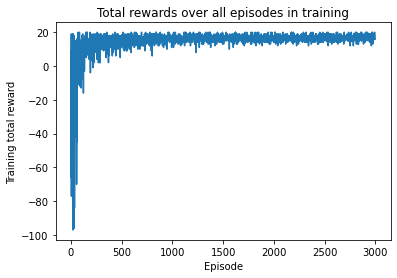

In [12]:
# Visualizing results and total reward over all episodes
x = range(NB_EPISODES)
plt.plot(x, training_rewards)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training')
plt.show()

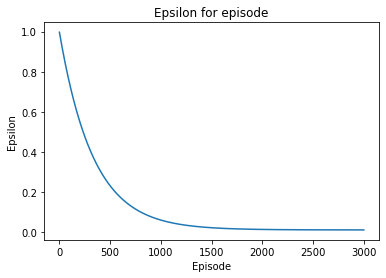

In [13]:
# Visualizing the epsilons over all episodes
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode")
plt.show()

Comparing to the Random Agent, we can see that the episodes on this Agent aren't mostly negative values. There are some negative values at the start, when the agent is *exploring* different actions for each state, but he ends up finding the best moves for each state, and we can notice a stabilization on the upper rewards.

### SARSA Agent

The SARSA Agent is very similar to the Q-Learning Agent, except for the update of the Q-table, which is made using a `new_action` instead of finding the action with the highest reward:

```python
self.Q[state, action] = self.Q[state, action] + self.alpha * (reward + self.discount_factor * self.Q[new_state, new_action] - self.Q[state, action])
```


In [14]:
class SARSAAgent:
    def __init__(self, observation_space=2300, action_space=12):
        """
        Initialize an agent and its parameters
        :param observation_space: How many possible states there are
        :param action_space: How many actions there are
        """
        self.Q = np.zeros((observation_space, action_space))

        self.alpha = 0.7  # learning rate
        self.discount_factor = 0.618
        self.epsilon = 1
        self.max_epsilon = 1
        self.min_epsilon = 0.01
        self.decay = 0.003

        self.board_dict = {}
        self.lastID = None

    def choice(self, env) -> int:
        """
        Given the environment, choose the action to take
        :param env: A Game environment
        :return: the action to take
        """
        # Choosing an action given the states based on a random number
        exp_exp_tradeoff = np.random.uniform(0, 1)

        if repr(env.observation) not in self.board_dict:
            if self.lastID:
                self.lastID += 1
            else:
                self.lastID = 0
            self.board_dict[repr(env.observation)] = self.lastID
            state = self.lastID
        else:
            state = self.board_dict[repr(env.observation)]
        # STEP 2: FIRST option for choosing the initial action - exploit
        # If the random number is larger than epsilon: employing exploitation
        # and selecting best action
        if exp_exp_tradeoff > self.epsilon:
            action = np.argmax(self.Q[state, :])
            # Sometimes the agent will try to exploit, but end up choosing a not valid move
            # To ensure that exploiting always provides good results, there's a check to verify if the
            # action is valid, if it is not, chooses a random valid move
            possible_moves = env.game.get_possible_moves(1, only_valid=True)
            if action not in possible_moves:
                i_random = np.random.randint(len(possible_moves))
                action = possible_moves[i_random]

        # STEP 2: SECOND option for choosing the initial action - explore
        # Otherwise, employing exploration: choosing a random action
        else:
            possible_moves = env.game.get_possible_moves(1, only_valid=True)
            i_random = np.random.randint(len(possible_moves))
            action = possible_moves[i_random]

        return action

    def update(self, obs, reward: int, done: bool, info: dict, env):
        """
        Updates the Q-table after performing an action, using an available action in the new state
        :param obs: New state that resulted from a action
        :param reward: The reward returned from applying a action to a state
        :param done: Boolean representing if the episode is finished
        :param info: Additional info from performing an action
        :param env: The environment
        """
        if repr(obs) not in self.board_dict:
            if not self.board_dict:
                self.board_dict[repr(obs)] = 0
                self.lastID = 0
            else:
                self.lastID += 1
                self.board_dict[repr(obs)] = self.lastID

        state = self.board_dict[repr(info["old_state"])]
        new_state = self.board_dict[repr(obs)]
        action = info['action']
        new_action = self.choice(env)

        self.Q[state, action] = self.Q[state, action] + self.alpha * (reward + self.discount_factor * self.Q[new_state, new_action] - self.Q[state, action])

    def episode_update(self, episode: int) -> None:
        """
        Update internals after each episode
        :param episode: Finished episode id
        """
        # Cutting down on exploration by reducing the epsilon
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.decay*episode)

With the final agent implemented, we can run the final game loop

In [15]:
env = NeutreekoEasyEnv(render_mode='terminal')
sarsa_agent = SARSAAgent()

# Creating lists to keep track of reward and epsilon values
training_rewards = []
epsilons = []

NB_EPISODES = 3000
for episode in range(1, NB_EPISODES + 1):
    # Resetting the environment each time as per requirement
    env.reset()
    # Starting the tracker for the rewards
    total_training_rewards = 0

    done = False
    while not done:
        action = sarsa_agent.choice(env)
        obs, reward, done, info = env.step(action)
        sarsa_agent.update(obs, reward, done, info, env)
        total_training_rewards += reward
    print(f"Episode {episode: <4} finished after {env.game.turns_count} turns")

    sarsa_agent.episode_update(episode)

    # Adding the total reward and reduced epsilon values
    training_rewards.append(total_training_rewards)
    epsilons.append(sarsa_agent.epsilon)
    
print(f'Highest board id -> {sarsa_agent.lastID}')
print(f'Q-table -> {sarsa_agent.Q}')
env.close()

Episode 1    finished after 2 turns
Episode 2    finished after 13 turns
Episode 3    finished after 38 turns
Episode 4    finished after 22 turns
Episode 5    finished after 76 turns
Episode 6    finished after 106 turns
Episode 7    finished after 11 turns
Episode 8    finished after 4 turns
Episode 9    finished after 63 turns
Episode 10   finished after 201 turns
Episode 11   finished after 21 turns
Episode 12   finished after 124 turns
Episode 13   finished after 5 turns
Episode 14   finished after 83 turns
Episode 15   finished after 189 turns
Episode 16   finished after 8 turns
Episode 17   finished after 28 turns
Episode 18   finished after 38 turns
Episode 19   finished after 12 turns
Episode 20   finished after 25 turns
Episode 21   finished after 4 turns
Episode 22   finished after 83 turns
Episode 23   finished after 66 turns
Episode 24   finished after 201 turns
Episode 25   finished after 41 turns
Episode 26   finished after 40 turns
Episode 27   finished after 62 turns
E

Episode 226  finished after 52 turns
Episode 227  finished after 40 turns
Episode 228  finished after 5 turns
Episode 229  finished after 15 turns
Episode 230  finished after 9 turns
Episode 231  finished after 31 turns
Episode 232  finished after 13 turns
Episode 233  finished after 4 turns
Episode 234  finished after 8 turns
Episode 235  finished after 28 turns
Episode 236  finished after 6 turns
Episode 237  finished after 6 turns
Episode 238  finished after 9 turns
Episode 239  finished after 9 turns
Episode 240  finished after 6 turns
Episode 241  finished after 3 turns
Episode 242  finished after 3 turns
Episode 243  finished after 1 turns
Episode 244  finished after 9 turns
Episode 245  finished after 17 turns
Episode 246  finished after 17 turns
Episode 247  finished after 2 turns
Episode 248  finished after 13 turns
Episode 249  finished after 8 turns
Episode 250  finished after 11 turns
Episode 251  finished after 10 turns
Episode 252  finished after 7 turns
Episode 253  fini

Episode 475  finished after 8 turns
Episode 476  finished after 3 turns
Episode 477  finished after 2 turns
Episode 478  finished after 14 turns
Episode 479  finished after 7 turns
Episode 480  finished after 8 turns
Episode 481  finished after 9 turns
Episode 482  finished after 5 turns
Episode 483  finished after 4 turns
Episode 484  finished after 4 turns
Episode 485  finished after 2 turns
Episode 486  finished after 3 turns
Episode 487  finished after 4 turns
Episode 488  finished after 6 turns
Episode 489  finished after 6 turns
Episode 490  finished after 5 turns
Episode 491  finished after 5 turns
Episode 492  finished after 4 turns
Episode 493  finished after 8 turns
Episode 494  finished after 10 turns
Episode 495  finished after 9 turns
Episode 496  finished after 14 turns
Episode 497  finished after 11 turns
Episode 498  finished after 7 turns
Episode 499  finished after 7 turns
Episode 500  finished after 21 turns
Episode 501  finished after 12 turns
Episode 502  finished 

Episode 730  finished after 13 turns
Episode 731  finished after 1 turns
Episode 732  finished after 4 turns
Episode 733  finished after 3 turns
Episode 734  finished after 6 turns
Episode 735  finished after 8 turns
Episode 736  finished after 4 turns
Episode 737  finished after 7 turns
Episode 738  finished after 4 turns
Episode 739  finished after 5 turns
Episode 740  finished after 4 turns
Episode 741  finished after 6 turns
Episode 742  finished after 7 turns
Episode 743  finished after 6 turns
Episode 744  finished after 6 turns
Episode 745  finished after 7 turns
Episode 746  finished after 2 turns
Episode 747  finished after 6 turns
Episode 748  finished after 7 turns
Episode 749  finished after 5 turns
Episode 750  finished after 5 turns
Episode 751  finished after 4 turns
Episode 752  finished after 3 turns
Episode 753  finished after 3 turns
Episode 754  finished after 8 turns
Episode 755  finished after 8 turns
Episode 756  finished after 3 turns
Episode 757  finished after

Episode 966  finished after 7 turns
Episode 967  finished after 1 turns
Episode 968  finished after 4 turns
Episode 969  finished after 5 turns
Episode 970  finished after 4 turns
Episode 971  finished after 2 turns
Episode 972  finished after 4 turns
Episode 973  finished after 11 turns
Episode 974  finished after 5 turns
Episode 975  finished after 1 turns
Episode 976  finished after 3 turns
Episode 977  finished after 5 turns
Episode 978  finished after 4 turns
Episode 979  finished after 3 turns
Episode 980  finished after 4 turns
Episode 981  finished after 3 turns
Episode 982  finished after 7 turns
Episode 983  finished after 4 turns
Episode 984  finished after 3 turns
Episode 985  finished after 9 turns
Episode 986  finished after 2 turns
Episode 987  finished after 5 turns
Episode 988  finished after 12 turns
Episode 989  finished after 10 turns
Episode 990  finished after 5 turns
Episode 991  finished after 5 turns
Episode 992  finished after 7 turns
Episode 993  finished aft

Episode 1229 finished after 7 turns
Episode 1230 finished after 5 turns
Episode 1231 finished after 7 turns
Episode 1232 finished after 4 turns
Episode 1233 finished after 5 turns
Episode 1234 finished after 3 turns
Episode 1235 finished after 7 turns
Episode 1236 finished after 3 turns
Episode 1237 finished after 3 turns
Episode 1238 finished after 6 turns
Episode 1239 finished after 6 turns
Episode 1240 finished after 7 turns
Episode 1241 finished after 5 turns
Episode 1242 finished after 5 turns
Episode 1243 finished after 2 turns
Episode 1244 finished after 6 turns
Episode 1245 finished after 4 turns
Episode 1246 finished after 7 turns
Episode 1247 finished after 5 turns
Episode 1248 finished after 7 turns
Episode 1249 finished after 4 turns
Episode 1250 finished after 7 turns
Episode 1251 finished after 5 turns
Episode 1252 finished after 2 turns
Episode 1253 finished after 2 turns
Episode 1254 finished after 3 turns
Episode 1255 finished after 7 turns
Episode 1256 finished after 

Episode 1493 finished after 9 turns
Episode 1494 finished after 5 turns
Episode 1495 finished after 3 turns
Episode 1496 finished after 2 turns
Episode 1497 finished after 5 turns
Episode 1498 finished after 6 turns
Episode 1499 finished after 4 turns
Episode 1500 finished after 4 turns
Episode 1501 finished after 4 turns
Episode 1502 finished after 5 turns
Episode 1503 finished after 6 turns
Episode 1504 finished after 5 turns
Episode 1505 finished after 5 turns
Episode 1506 finished after 3 turns
Episode 1507 finished after 7 turns
Episode 1508 finished after 2 turns
Episode 1509 finished after 7 turns
Episode 1510 finished after 5 turns
Episode 1511 finished after 8 turns
Episode 1512 finished after 7 turns
Episode 1513 finished after 3 turns
Episode 1514 finished after 5 turns
Episode 1515 finished after 10 turns
Episode 1516 finished after 3 turns
Episode 1517 finished after 1 turns
Episode 1518 finished after 7 turns
Episode 1519 finished after 4 turns
Episode 1520 finished after

Episode 1722 finished after 8 turns
Episode 1723 finished after 5 turns
Episode 1724 finished after 5 turns
Episode 1725 finished after 4 turns
Episode 1726 finished after 7 turns
Episode 1727 finished after 5 turns
Episode 1728 finished after 4 turns
Episode 1729 finished after 5 turns
Episode 1730 finished after 3 turns
Episode 1731 finished after 5 turns
Episode 1732 finished after 4 turns
Episode 1733 finished after 6 turns
Episode 1734 finished after 5 turns
Episode 1735 finished after 4 turns
Episode 1736 finished after 5 turns
Episode 1737 finished after 6 turns
Episode 1738 finished after 4 turns
Episode 1739 finished after 7 turns
Episode 1740 finished after 4 turns
Episode 1741 finished after 2 turns
Episode 1742 finished after 6 turns
Episode 1743 finished after 4 turns
Episode 1744 finished after 5 turns
Episode 1745 finished after 6 turns
Episode 1746 finished after 3 turns
Episode 1747 finished after 3 turns
Episode 1748 finished after 2 turns
Episode 1749 finished after 

Episode 1954 finished after 4 turns
Episode 1955 finished after 2 turns
Episode 1956 finished after 3 turns
Episode 1957 finished after 3 turns
Episode 1958 finished after 3 turns
Episode 1959 finished after 3 turns
Episode 1960 finished after 4 turns
Episode 1961 finished after 1 turns
Episode 1962 finished after 3 turns
Episode 1963 finished after 4 turns
Episode 1964 finished after 2 turns
Episode 1965 finished after 6 turns
Episode 1966 finished after 7 turns
Episode 1967 finished after 4 turns
Episode 1968 finished after 5 turns
Episode 1969 finished after 4 turns
Episode 1970 finished after 3 turns
Episode 1971 finished after 4 turns
Episode 1972 finished after 7 turns
Episode 1973 finished after 5 turns
Episode 1974 finished after 3 turns
Episode 1975 finished after 4 turns
Episode 1976 finished after 3 turns
Episode 1977 finished after 3 turns
Episode 1978 finished after 2 turns
Episode 1979 finished after 3 turns
Episode 1980 finished after 5 turns
Episode 1981 finished after 

Episode 2198 finished after 5 turns
Episode 2199 finished after 4 turns
Episode 2200 finished after 4 turns
Episode 2201 finished after 6 turns
Episode 2202 finished after 5 turns
Episode 2203 finished after 5 turns
Episode 2204 finished after 5 turns
Episode 2205 finished after 4 turns
Episode 2206 finished after 5 turns
Episode 2207 finished after 8 turns
Episode 2208 finished after 4 turns
Episode 2209 finished after 7 turns
Episode 2210 finished after 4 turns
Episode 2211 finished after 6 turns
Episode 2212 finished after 5 turns
Episode 2213 finished after 4 turns
Episode 2214 finished after 3 turns
Episode 2215 finished after 1 turns
Episode 2216 finished after 5 turns
Episode 2217 finished after 7 turns
Episode 2218 finished after 5 turns
Episode 2219 finished after 3 turns
Episode 2220 finished after 2 turns
Episode 2221 finished after 3 turns
Episode 2222 finished after 5 turns
Episode 2223 finished after 2 turns
Episode 2224 finished after 2 turns
Episode 2225 finished after 

Episode 2449 finished after 5 turns
Episode 2450 finished after 7 turns
Episode 2451 finished after 4 turns
Episode 2452 finished after 5 turns
Episode 2453 finished after 3 turns
Episode 2454 finished after 5 turns
Episode 2455 finished after 4 turns
Episode 2456 finished after 5 turns
Episode 2457 finished after 3 turns
Episode 2458 finished after 6 turns
Episode 2459 finished after 5 turns
Episode 2460 finished after 4 turns
Episode 2461 finished after 3 turns
Episode 2462 finished after 4 turns
Episode 2463 finished after 6 turns
Episode 2464 finished after 4 turns
Episode 2465 finished after 5 turns
Episode 2466 finished after 2 turns
Episode 2467 finished after 3 turns
Episode 2468 finished after 6 turns
Episode 2469 finished after 2 turns
Episode 2470 finished after 4 turns
Episode 2471 finished after 5 turns
Episode 2472 finished after 6 turns
Episode 2473 finished after 1 turns
Episode 2474 finished after 5 turns
Episode 2475 finished after 2 turns
Episode 2476 finished after 

Episode 2701 finished after 5 turns
Episode 2702 finished after 4 turns
Episode 2703 finished after 3 turns
Episode 2704 finished after 5 turns
Episode 2705 finished after 6 turns
Episode 2706 finished after 4 turns
Episode 2707 finished after 9 turns
Episode 2708 finished after 1 turns
Episode 2709 finished after 3 turns
Episode 2710 finished after 5 turns
Episode 2711 finished after 6 turns
Episode 2712 finished after 2 turns
Episode 2713 finished after 3 turns
Episode 2714 finished after 5 turns
Episode 2715 finished after 3 turns
Episode 2716 finished after 3 turns
Episode 2717 finished after 4 turns
Episode 2718 finished after 4 turns
Episode 2719 finished after 3 turns
Episode 2720 finished after 3 turns
Episode 2721 finished after 3 turns
Episode 2722 finished after 4 turns
Episode 2723 finished after 3 turns
Episode 2724 finished after 4 turns
Episode 2725 finished after 3 turns
Episode 2726 finished after 5 turns
Episode 2727 finished after 5 turns
Episode 2728 finished after 

Episode 2929 finished after 4 turns
Episode 2930 finished after 4 turns
Episode 2931 finished after 2 turns
Episode 2932 finished after 4 turns
Episode 2933 finished after 6 turns
Episode 2934 finished after 2 turns
Episode 2935 finished after 1 turns
Episode 2936 finished after 3 turns
Episode 2937 finished after 5 turns
Episode 2938 finished after 5 turns
Episode 2939 finished after 2 turns
Episode 2940 finished after 4 turns
Episode 2941 finished after 1 turns
Episode 2942 finished after 6 turns
Episode 2943 finished after 6 turns
Episode 2944 finished after 5 turns
Episode 2945 finished after 5 turns
Episode 2946 finished after 5 turns
Episode 2947 finished after 6 turns
Episode 2948 finished after 5 turns
Episode 2949 finished after 3 turns
Episode 2950 finished after 3 turns
Episode 2951 finished after 2 turns
Episode 2952 finished after 4 turns
Episode 2953 finished after 5 turns
Episode 2954 finished after 8 turns
Episode 2955 finished after 7 turns
Episode 2956 finished after 

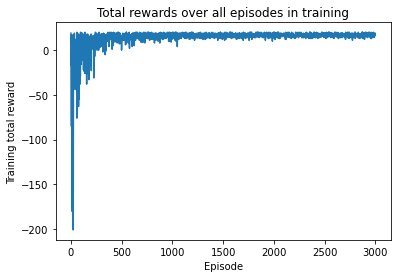

In [16]:
# Visualizing results and total reward over all episodes
x = range(NB_EPISODES)
plt.plot(x, training_rewards)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training')
plt.show()

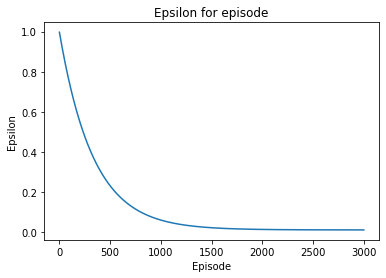

In [17]:
# Visualizing the epsilons over all episodes
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode")
plt.show()


## Conclusions

Both the Q-Learning Agent and the SARSA Agent were able to learn to play the game, and with enought episodes, they can try out every possible state (2300) and always be able to make the best moves and finish the game is the least amount of moves